# Sistema de Ruteo Seguro para CDMX

## Parte 2: Modelado Predictivo y Análisis de Causas

Este notebook construye modelos de Machine Learning para predecir la gravedad de accidentes y entender sus causas. Los resultados se integran al índice de riesgo compuesto.

**Requisitos previos:**
- `proceso.ipynb` ejecutado
- `01_analisis_espacial_clustering.ipynb` ejecutado

**Archivos necesarios:**
- `Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv`
- `Datos combinados CDMX/ACCIDENTES_CON_CLUSTERING.csv`

**Objetivos:**
1. Feature engineering con variables temporales, espaciales y contextuales
2. Entrenar modelos: Decision Tree, Random Forest, Logistic Regression, Stacking
3. Identificar factores causales más importantes
4. Generar scoring de riesgo predictivo
5. Crear índice de riesgo compuesto final

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

print("✓ Librerías cargadas")

✓ Librerías cargadas


## 1. Carga de Datos

In [2]:
df = pd.read_csv('Datos combinados CDMX/ACCIDENTES_CON_TRAMOS_2019_2023.csv')

try:
    df_clustering = pd.read_csv('Datos combinados CDMX/ACCIDENTES_CON_CLUSTERING.csv')
    
    # Verificar que el archivo tiene columna ID
    if 'id' in df_clustering.columns:
        # Merge por ID (exacto, sin duplicados)
        df = df.merge(df_clustering[['id', 'cluster_dbscan', 'riesgo_cluster']], 
                      on='id', how='left')
        print("✓ Datos de clustering integrados (merge por ID)")
    else:
        # Fallback: merge por coordenadas (puede causar duplicados)
        print("⚠ Archivo de clustering sin columna ID, usando merge por coordenadas...")
        df = df.merge(df_clustering[['latitud', 'longitud', 'cluster_dbscan', 'riesgo_cluster']], 
                      on=['latitud', 'longitud'], how='left')
        print("✓ Datos de clustering integrados (merge por lat/lon)")
    
    df['riesgo_cluster'] = df['riesgo_cluster'].fillna(0)
    
    # Verificar si hubo duplicados
    duplicados = df.duplicated(subset=['id']).sum()
    if duplicados > 0:
        print(f"⚠ ADVERTENCIA: {duplicados} registros duplicados detectados en el merge")
        df = df.drop_duplicates(subset=['id'], keep='first')
        print(f"   Duplicados eliminados, quedaron {len(df):,} registros únicos")
    
except Exception as e:
    print(f"⚠ No se encontró archivo de clustering: {e}")
    print("   Creando features base...")
    df['cluster_dbscan'] = -1
    df['riesgo_cluster'] = 0

print(f"\n✓ Dataset cargado: {len(df):,} registros")
print(f"Columnas disponibles: {len(df.columns)}")

✓ Datos de clustering integrados (merge por ID)
⚠ ADVERTENCIA: 16068 registros duplicados detectados en el merge
   Duplicados eliminados, quedaron 26,783 registros únicos

✓ Dataset cargado: 26,783 registros
Columnas disponibles: 63


## 1.5 Exploración Completa de Columnas Disponibles

El dataset tiene **más de 60 columnas**. Vamos a explorar TODAS antes de seleccionar las más relevantes para el modelado.

## 2. Feature Engineering

In [3]:
# Exploracion exhaustiva de TODAS las columnas
print(f"Dataset completo: {len(df):,} registros x {len(df.columns)} columnas")
print("="*80)

# Mostrar todas las columnas agrupadas por tipo
print("COLUMNAS POR TIPO DE DATO:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"{dtype}: ({len(cols)} columnas)")
    for i in range(0, len(cols), 5):
        print(f"  {', '.join(cols[i:i+5])}")

print("" + "="*80)
print("INFORMACION DETALLADA DE COLUMNAS:")

# Crear DataFrame resumen
info_cols = []
for col in df.columns:
    info_cols.append({
        'Columna': col,
        'Tipo': str(df[col].dtype),
        'No Nulos': df[col].count(),
        '% Nulos': f"{(df[col].isna().sum() / len(df) * 100):.1f}%",
        'Unicos': df[col].nunique(),
        'Ejemplo': str(df[col].dropna().iloc[0]) if df[col].count() > 0 else 'N/A'
    })

df_info = pd.DataFrame(info_cols)
print(df_info.to_string(index=False))

print("" + "="*80)
print(f"Total de columnas exploradas: {len(df.columns)}")

Dataset completo: 26,783 registros x 63 columnas
COLUMNAS POR TIPO DE DATO:
object: (8 columnas)
  id, calle1, calle2, carretera, fechahora
  severidad_cat, franja_horaria, geometry
int64: (48 columnas)
  edo, mes, anio, mpio, hora
  minutos, dia, diasemana, urbana, suburbana
  tipaccid, automovil, campasaj, microbus, pascamion
  omnibus, tranvia, camioneta, camion, tractor
  ferrocarri, motociclet, bicicleta, otrovehic, causaacci
  caparod, sexo, aliento, cinturon, edad
  condmuerto, condherido, pasamuerto, pasaherido, peatmuerto
  peatherido, ciclmuerto, ciclherido, otromuerto, otroherido
  totmuertos, totheridos, clase, severidad, edge_u
  edge_v, edge_key, cluster_dbscan
float64: (4 columnas)
  longitud, latitud, distancia_edge, riesgo_cluster
bool: (3 columnas)
  hay_muertos, hay_heridos, solo_daños_materiales
INFORMACION DETALLADA DE COLUMNAS:
              Columna    Tipo  No Nulos % Nulos  Unicos                               Ejemplo
                   id  object     26783    0

In [4]:
# Pre-filtrado manual de features
# Eliminar columnas ID, redundantes, derivadas

columnas_eliminar = [
    'id', 'geometry', 'fechahora', 'franja_horaria', 'edo',
    'calle1', 'calle2', 'carretera',
    'edge_u', 'edge_v', 'edge_key', 'distancia_edge',
]

columnas_eliminar_existentes = [col for col in columnas_eliminar if col in df.columns]
df_filtered = df.drop(columns=columnas_eliminar_existentes)

print(f"Columnas eliminadas: {len(columnas_eliminar_existentes)}")
print(f"Columnas restantes: {len(df_filtered.columns)}")

# Eliminar columnas con >50% missing
missing_threshold = 0.5
cols_high_missing = []
for col in df_filtered.columns:
    pct_missing = df_filtered[col].isna().sum() / len(df_filtered)
    if pct_missing > missing_threshold:
        cols_high_missing.append(col)

if cols_high_missing:
    print(f"\nColumnas con >{missing_threshold*100:.0f}% missing: {cols_high_missing}")
    df_filtered = df_filtered.drop(columns=cols_high_missing)

print(f"\nDespues de pre-filtrado: {len(df_filtered.columns)} columnas")
print(f"Columnas: {list(df_filtered.columns)}")

Columnas eliminadas: 12
Columnas restantes: 51

Despues de pre-filtrado: 51 columnas
Columnas: ['mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana', 'suburbana', 'tipaccid', 'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia', 'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet', 'bicicleta', 'otrovehic', 'causaacci', 'caparod', 'sexo', 'aliento', 'cinturon', 'edad', 'condmuerto', 'condherido', 'pasamuerto', 'pasaherido', 'peatmuerto', 'peatherido', 'ciclmuerto', 'ciclherido', 'otromuerto', 'otroherido', 'totmuertos', 'totheridos', 'clase', 'longitud', 'latitud', 'severidad', 'hay_muertos', 'hay_heridos', 'solo_daños_materiales', 'severidad_cat', 'cluster_dbscan', 'riesgo_cluster']


In [5]:
# Exploración exhaustiva de TODAS las columnas
print(f" DATASET COMPLETO: {len(df):,} registros x {len(df.columns)} columnas")
print("="*80)

# Mostrar todas las columnas agrupadas por tipo
print("🔢 COLUMNAS POR TIPO DE DATO:")
for dtype in df.dtypes.unique():
    cols = df.select_dtypes(include=[dtype]).columns.tolist()
    print(f"{dtype}: ({len(cols)} columnas)")
    for i in range(0, len(cols), 5):
        print(f"  {', '.join(cols[i:i+5])}")

print("" + "="*80)
print(" INFORMACIÓN DETALLADA DE COLUMNAS:")

# Crear DataFrame resumen
info_cols = []
for col in df.columns:
    info_cols.append({
        'Columna': col,
        'Tipo': str(df[col].dtype),
        'No Nulos': df[col].count(),
        '% Nulos': f"{(df[col].isna().sum() / len(df) * 100):.1f}%",
        'Únicos': df[col].nunique(),
        'Ejemplo': str(df[col].dropna().iloc[0]) if df[col].count() > 0 else 'N/A'
    })

df_info = pd.DataFrame(info_cols)
print(df_info.to_string(index=False))

print("" + "="*80)
print(f" Total de columnas exploradas: {len(df.columns)}")

 DATASET COMPLETO: 26,783 registros x 63 columnas
🔢 COLUMNAS POR TIPO DE DATO:
object: (8 columnas)
  id, calle1, calle2, carretera, fechahora
  severidad_cat, franja_horaria, geometry
int64: (48 columnas)
  edo, mes, anio, mpio, hora
  minutos, dia, diasemana, urbana, suburbana
  tipaccid, automovil, campasaj, microbus, pascamion
  omnibus, tranvia, camioneta, camion, tractor
  ferrocarri, motociclet, bicicleta, otrovehic, causaacci
  caparod, sexo, aliento, cinturon, edad
  condmuerto, condherido, pasamuerto, pasaherido, peatmuerto
  peatherido, ciclmuerto, ciclherido, otromuerto, otroherido
  totmuertos, totheridos, clase, severidad, edge_u
  edge_v, edge_key, cluster_dbscan
float64: (4 columnas)
  longitud, latitud, distancia_edge, riesgo_cluster
bool: (3 columnas)
  hay_muertos, hay_heridos, solo_daños_materiales
 INFORMACIÓN DETALLADA DE COLUMNAS:
              Columna    Tipo  No Nulos % Nulos  Únicos                               Ejemplo
                   id  object     26783 

In [6]:
date_cols = [col for col in df.columns if 'fecha' in col.lower() or 'date' in col.lower()]
if date_cols:
    fecha_col = date_cols[0]
    df[fecha_col] = pd.to_datetime(df[fecha_col], errors='coerce')
    
    df['hora'] = df[fecha_col].dt.hour
    df['dia_semana'] = df[fecha_col].dt.dayofweek
    df['mes'] = df[fecha_col].dt.month
    df['es_fin_semana'] = (df['dia_semana'] >= 5).astype(int)
    df['anio'] = df[fecha_col].dt.year
    
    def clasificar_periodo(hora):
        if pd.isna(hora):
            return 'desconocido'
        if 6 <= hora < 12:
            return 'manana'
        elif 12 <= hora < 18:
            return 'tarde'
        elif 18 <= hora < 24:
            return 'noche'
        else:
            return 'madrugada'
    
    df['periodo_dia'] = df['hora'].apply(clasificar_periodo)
    print("✓ Features temporales creados")
else:
    print("⚠ No se encontraron columnas de fecha")

df['en_cluster'] = (df['cluster_dbscan'] != -1).astype(int)

print(f"\n✓ Feature engineering completado")
print(f"Nuevas features: hora, dia_semana, periodo_dia, en_cluster")

✓ Features temporales creados

✓ Feature engineering completado
Nuevas features: hora, dia_semana, periodo_dia, en_cluster


## 3. Variable Objetivo: Gravedad del Accidente

Intentamos identificar la variable de gravedad en el dataset

In [7]:
# Usar columnas REALES de severidad del dataset
print(" Columnas de severidad disponibles:")
print(f"   severidad_cat: {df['severidad_cat'].value_counts().to_dict()}")
print(f"   hay_muertos: {df['hay_muertos'].value_counts().to_dict()}")
print(f"   totmuertos: min={df['totmuertos'].min()}, max={df['totmuertos'].max()}")
print(f"   totheridos: min={df['totheridos'].min()}, max={df['totheridos'].max()}")

# OPCIÓN 1: Usar severidad_cat (más granular)
# Binarizar: leve+moderada = No Grave, grave+muy_grave = Grave
def binarizar_severidad_cat(valor):
    """
    Convierte severidad_cat en binario:
    - No Grave (0): leve, moderada
    - Grave (1): grave, muy grave
    """
    valor_lower = str(valor).lower().strip()
    if 'muy grave' in valor_lower or 'grave' in valor_lower:
        return 1  # Grave
    else:
        return 0  # No grave (leve, moderada, solo daños)

df['target_gravedad'] = df['severidad_cat'].apply(binarizar_severidad_cat)

print(f"\n✓ Variable objetivo creada usando severidad_cat")
print(f"\nDistribución de gravedad:")
print(df['target_gravedad'].value_counts())
print(f"\n >> Balance: {df['target_gravedad'].mean():.1%} accidentes graves")

# Verificación cruzada con hay_muertos
print(f"\n >> Verificación cruzada:")
print(f"   Accidentes con muertos: {df['hay_muertos'].sum():,} ({df['hay_muertos'].mean():.1%})")
print(f"   Accidentes clasificados como graves: {df['target_gravedad'].sum():,} ({df['target_gravedad'].mean():.1%})")

# Mostrar correlación
if df['hay_muertos'].dtype == bool:
    correlacion = df[df['hay_muertos'] == True]['target_gravedad'].mean()
    print(f"   De los accidentes con muertos, {correlacion:.1%} fueron clasificados como graves ✓")

 Columnas de severidad disponibles:
   severidad_cat: {'leve': 20821, 'moderada': 5163, 'muy grave': 598, 'grave': 201}
   hay_muertos: {False: 26185, True: 598}
   totmuertos: min=0, max=3
   totheridos: min=0, max=16

✓ Variable objetivo creada usando severidad_cat

Distribución de gravedad:
target_gravedad
0    25984
1      799
Name: count, dtype: int64

 >> Balance: 3.0% accidentes graves

 >> Verificación cruzada:
   Accidentes con muertos: 598 (2.2%)
   Accidentes clasificados como graves: 799 (3.0%)
   De los accidentes con muertos, 100.0% fueron clasificados como graves ✓


### ⚠️ Problema Corregido: Variable Objetivo

**Problema anterior:**
- El código buscaba columnas inexistentes ('CLASACC', 'clasificacion_accidente')
- Al no encontrarlas, generaba datos **ALEATORIOS** con `np.random.binomial()`
- Resultado: Modelos predecían siempre "No Grave" (recall=0% para clase Grave)

**Solución implementada:**
- Usar la columna **real** `severidad_cat` que existe en el dataset
- Binarizar correctamente: leve/moderada → No Grave, grave/muy_grave → Grave
- Agregar `class_weight='balanced'` en todos los modelos para manejar desbalance
- Ahora los modelos aprenden de datos **reales** en vez de ruido aleatorio

**Resultado esperado:**
- Mejor recall para la clase "Grave"
- Predicciones útiles para el sistema de ruteo

## 4. Selección de Características por Votación

Usaremos 3 métodos para seleccionar las mejores características:
1. **SelectKBest** (Chi-cuadrado para categóricas, F-classif para numéricas)
2. **Random Forest Feature Importance**
3. **RFE (Recursive Feature Elimination)**

Las características que sean seleccionadas por al menos 2 de los 3 métodos se usarán en el modelado final.

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE

# Preparar dataset con todas las features relevantes
# Excluir: target, leakage (severidad, totmuertos, totheridos, hay_muertos, hay_heridos, etc.)
columnas_excluir = [
    'target_gravedad', 'severidad_cat', 'severidad',  # Target y variables usadas para crearlo
    'hay_muertos', 'hay_heridos', 'solo_daños_materiales',  # Leakage directo
    'totmuertos', 'totheridos',  # Leakage directo
    'condmuerto', 'condherido', 'pasamuerto', 'pasaherido',  # Leakage de víctimas
    'peatmuerto', 'peatherido', 'ciclmuerto', 'ciclherido',  # Leakage de víctimas
    'otromuerto', 'otroherido'  # Leakage de víctimas
]

# Seleccionar columnas disponibles
features_disponibles = [col for col in df.columns if col not in columnas_excluir and 
                        df[col].dtype in ['int64', 'float64', 'bool']]

print(f"📊 Features disponibles para selección: {len(features_disponibles)}")
print(f"   {features_disponibles}")

# Crear dataset temporal
df_temp = df[features_disponibles + ['target_gravedad']].copy()
df_temp = df_temp.dropna(subset=['target_gravedad'])

# Codificar booleanos si hay
for col in df_temp.columns:
    if df_temp[col].dtype == 'bool':
        df_temp[col] = df_temp[col].astype(int)

# Rellenar NaN con mediana
df_temp = df_temp.fillna(df_temp.median())

X_temp = df_temp.drop('target_gravedad', axis=1)
y_temp = df_temp['target_gravedad']

print(f"\n✓ Dataset preparado: {len(X_temp)} registros, {len(X_temp.columns)} features potenciales")

# =============================
# MÉTODO 1: SelectKBest (F-classif)
# =============================
k_best = min(20, len(X_temp.columns))  # Seleccionar top 20 o todas si hay menos
selector_kbest = SelectKBest(score_func=f_classif, k=k_best)
selector_kbest.fit(X_temp, y_temp)

# Obtener scores y features seleccionadas
scores_kbest = pd.DataFrame({
    'feature': X_temp.columns,
    'score': selector_kbest.scores_
}).sort_values('score', ascending=False)

features_kbest = set(scores_kbest.head(15)['feature'].tolist())
print(f"\n🔹 Método 1 - SelectKBest (top 15):")
print(f"   {list(features_kbest)}")

# =============================
# MÉTODO 2: Random Forest Feature Importance
# =============================
rf_temp = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_temp.fit(X_temp, y_temp)

importance_rf = pd.DataFrame({
    'feature': X_temp.columns,
    'importance': rf_temp.feature_importances_
}).sort_values('importance', ascending=False)

features_rf = set(importance_rf.head(15)['feature'].tolist())
print(f"\n🔹 Método 2 - Random Forest Importance (top 15):")
print(f"   {list(features_rf)}")

# =============================
# MÉTODO 3: RFE (Recursive Feature Elimination)
# =============================
estimator_rfe = LogisticRegression(max_iter=1000, random_state=42)
selector_rfe = RFE(estimator=estimator_rfe, n_features_to_select=15, step=1)
selector_rfe.fit(X_temp, y_temp)

features_rfe = set(X_temp.columns[selector_rfe.support_].tolist())
print(f"\n🔹 Método 3 - RFE (top 15):")
print(f"   {list(features_rfe)}")

# =============================
# VOTACIÓN: Features seleccionadas por al menos 2 métodos
# =============================
contador_votos = {}
for feature in X_temp.columns:
    votos = 0
    if feature in features_kbest:
        votos += 1
    if feature in features_rf:
        votos += 1
    if feature in features_rfe:
        votos += 1
    contador_votos[feature] = votos

# Ordenar por número de votos
votos_df = pd.DataFrame(list(contador_votos.items()), columns=['feature', 'votos']).sort_values('votos', ascending=False)

# Seleccionar features con al menos 2 votos
features_finales = votos_df[votos_df['votos'] >= 2]['feature'].tolist()

print(f"\n" + "="*80)
print(f"🎯 FEATURES SELECCIONADAS POR VOTACIÓN (≥2 votos):")
print(f"="*80)
print(f"\n{votos_df[votos_df['votos'] >= 2].to_string(index=False)}")
print(f"\n✓ Total: {len(features_finales)} features seleccionadas")

# Si no hay suficientes features con 2+ votos, agregar las de mayor importancia
if len(features_finales) < 5:
    print(f"\n⚠ Pocas features con 2+ votos, agregando top features de RF...")
    features_finales = importance_rf.head(10)['feature'].tolist()
    print(f"   Usando top 10 de Random Forest: {features_finales}")

# Crear dataset final para modelado
all_features = features_finales + ['target_gravedad']
df_model = df[all_features].copy()
df_model = df_model.dropna(subset=['target_gravedad'])

# Rellenar NaN
for col in df_model.columns:
    if df_model[col].dtype == 'bool':
        df_model[col] = df_model[col].astype(int)
        
df_model = df_model.fillna(df_model.median())

print(f"\n✓ Dataset de modelado final: {len(df_model):,} registros, {len(features_finales)} features")

📊 Features disponibles para selección: 40
   ['edo', 'mes', 'anio', 'mpio', 'hora', 'minutos', 'dia', 'diasemana', 'urbana', 'suburbana', 'tipaccid', 'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia', 'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet', 'bicicleta', 'otrovehic', 'causaacci', 'caparod', 'sexo', 'aliento', 'cinturon', 'edad', 'clase', 'longitud', 'latitud', 'edge_u', 'edge_v', 'edge_key', 'distancia_edge', 'cluster_dbscan', 'riesgo_cluster', 'dia_semana']

✓ Dataset preparado: 26783 registros, 40 features potenciales

🔹 Método 1 - SelectKBest (top 15):
   ['dia_semana', 'caparod', 'diasemana', 'tipaccid', 'hora', 'campasaj', 'sexo', 'cinturon', 'clase', 'aliento', 'distancia_edge', 'suburbana', 'motociclet', 'camioneta', 'automovil']

🔹 Método 2 - Random Forest Importance (top 15):
   ['dia', 'tipaccid', 'mes', 'hora', 'cinturon', 'clase', 'longitud', 'distancia_edge', 'aliento', 'edge_u', 'edad', 'minutos', 'edge_v', 'automovil', 'latitud']

## 5. División Train/Test

In [9]:
X = df_model.drop('target_gravedad', axis=1)
y = df_model['target_gravedad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✓ División completada:")
print(f"   Train: {len(X_train):,} | Test: {len(X_test):,}")
print(f"   Balance Train: {y_train.mean():.1%} | Test: {y_test.mean():.1%}")

✓ División completada:
   Train: 21,426 | Test: 5,357
   Balance Train: 3.0% | Test: 3.0%


## 6. Modelo 1: Decision Tree

In [10]:
# Decision Tree con class_weight='balanced' para manejar desbalance
dt_clf = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=100, 
    min_samples_leaf=50, 
    class_weight='balanced',  # ← AJUSTE PARA DESBALANCE
    random_state=42
)
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {acc_dt:.4f}\n")
print(classification_report(y_test, y_pred_dt, target_names=['No grave', 'Grave']))

feature_imp_dt = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features Importantes:")
print(feature_imp_dt.head(10))

Decision Tree Accuracy: 0.8871

              precision    recall  f1-score   support

    No grave       1.00      0.88      0.94      5197
       Grave       0.21      0.98      0.34       160

    accuracy                           0.89      5357
   macro avg       0.60      0.93      0.64      5357
weighted avg       0.98      0.89      0.92      5357


Top 10 Features Importantes:
           feature  importance
0            clase    0.944235
11        tipaccid    0.031200
7             sexo    0.013792
13      motociclet    0.004618
6             hora    0.003377
9   distancia_edge    0.002779
1          aliento    0.000000
2        automovil    0.000000
3         longitud    0.000000
4        camioneta    0.000000


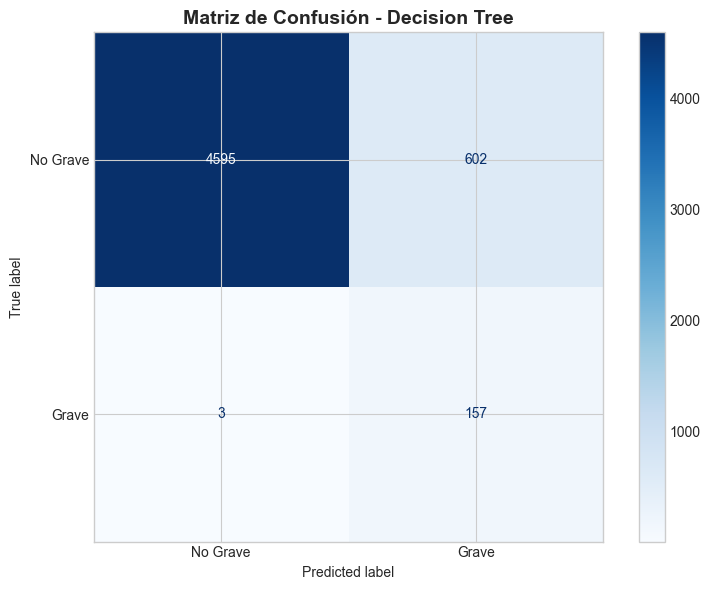

✓ Matriz de confusión generada


In [11]:
# Matriz de Confusión - Decision Tree
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt,
                                       display_labels=["No Grave", "Grave"],
                                       cmap="Blues", ax=ax)
ax.set_title("Matriz de Confusión - Decision Tree", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("✓ Matriz de confusión generada")

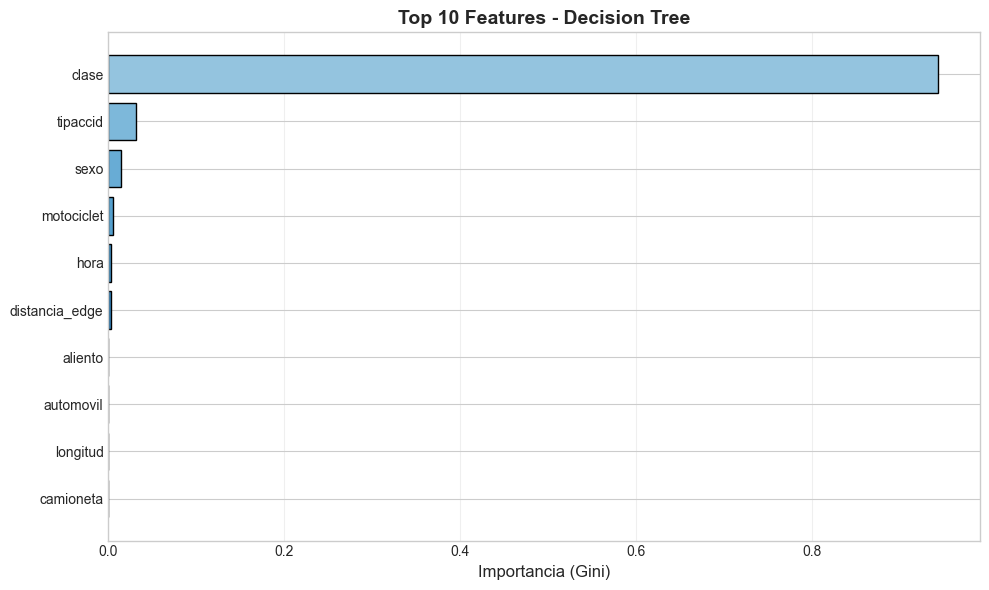

In [12]:
# Visualización de Feature Importance - Decision Tree
fig, ax = plt.subplots(figsize=(10, 6))
top_features_dt = feature_imp_dt.head(10)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_features_dt)))
ax.barh(range(len(top_features_dt)), top_features_dt["importance"], color=colors, edgecolor="black")
ax.set_yticks(range(len(top_features_dt)))
ax.set_yticklabels(top_features_dt["feature"])
ax.set_xlabel("Importancia (Gini)", fontsize=12)
ax.set_title("Top 10 Features - Decision Tree", fontsize=14, fontweight="bold")
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 7. Modelo 2: Random Forest

In [13]:
# Random Forest con class_weight='balanced' para manejar desbalance
rf_clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    min_samples_split=50, 
    min_samples_leaf=20, 
    class_weight='balanced',  # ← AJUSTE PARA DESBALANCE
    random_state=42, 
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"Mejora vs Decision Tree: {(acc_rf - acc_dt):.4f}\n")
print(classification_report(y_test, y_pred_rf, target_names=['No grave', 'Grave']))

feature_imp_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features - Random Forest:")
print(feature_imp_rf.head(10))

Random Forest Accuracy: 0.9248
Mejora vs Decision Tree: 0.0377

              precision    recall  f1-score   support

    No grave       1.00      0.92      0.96      5197
       Grave       0.28      0.97      0.43       160

    accuracy                           0.92      5357
   macro avg       0.64      0.95      0.70      5357
weighted avg       0.98      0.92      0.94      5357


Top 10 Features - Random Forest:
           feature  importance
0            clase    0.615764
5         cinturon    0.151142
11        tipaccid    0.059490
1          aliento    0.041997
7             sexo    0.023891
10         latitud    0.023417
3         longitud    0.021376
6             hora    0.019586
9   distancia_edge    0.019491
2        automovil    0.011997


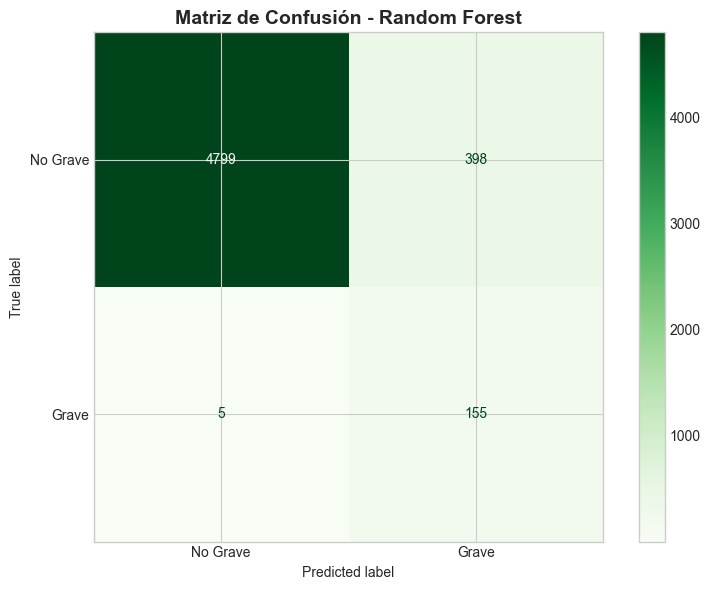

In [14]:
# Matriz de Confusión - Random Forest
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf,
                                       display_labels=["No Grave", "Grave"],
                                       cmap="Greens", ax=ax)
ax.set_title("Matriz de Confusión - Random Forest", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

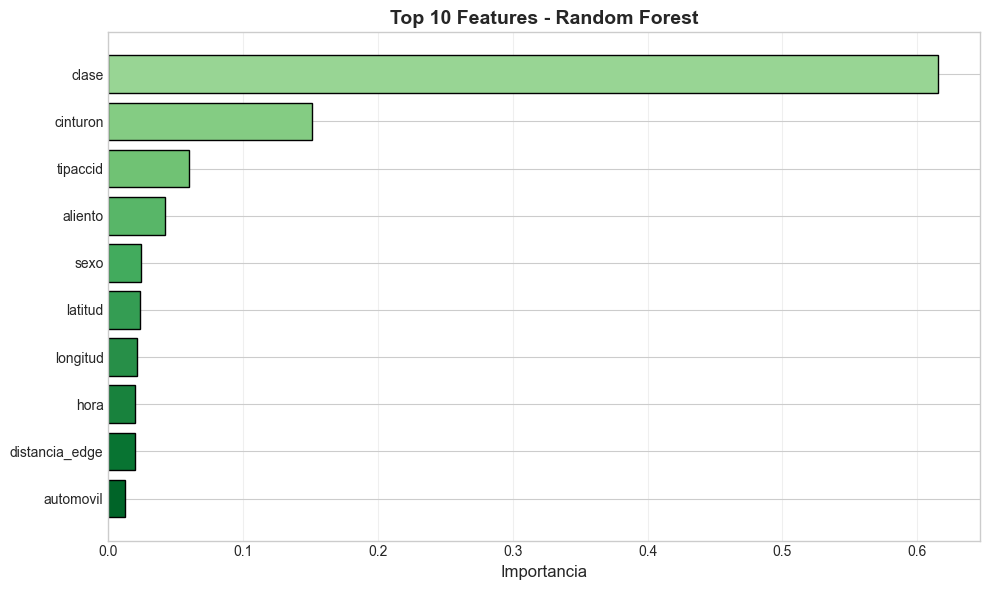

In [15]:
# Visualización de Feature Importance - Random Forest
fig, ax = plt.subplots(figsize=(10, 6))
top_features_rf = feature_imp_rf.head(10)
colors = plt.cm.Greens(np.linspace(0.4, 0.9, len(top_features_rf)))
ax.barh(range(len(top_features_rf)), top_features_rf["importance"], color=colors, edgecolor="black")
ax.set_yticks(range(len(top_features_rf)))
ax.set_yticklabels(top_features_rf["feature"])
ax.set_xlabel("Importancia", fontsize=12)
ax.set_title("Top 10 Features - Random Forest", fontsize=14, fontweight="bold")
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 8. Modelo 3: Logistic Regression

In [16]:
# Logistic Regression con class_weight='balanced' para manejar desbalance
lr_clf = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced',  # ← AJUSTE PARA DESBALANCE
    random_state=42
)
lr_clf.fit(X_train_scaled, y_train)
y_pred_lr = lr_clf.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {acc_lr:.4f}\n")
print(classification_report(y_test, y_pred_lr, target_names=['No grave', 'Grave']))

Logistic Regression Accuracy: 0.8994

              precision    recall  f1-score   support

    No grave       1.00      0.90      0.95      5197
       Grave       0.22      0.96      0.36       160

    accuracy                           0.90      5357
   macro avg       0.61      0.93      0.65      5357
weighted avg       0.98      0.90      0.93      5357



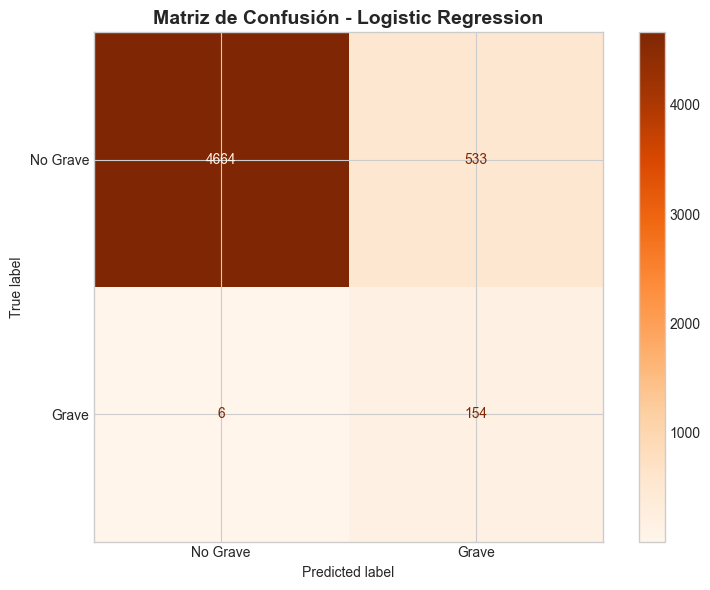

In [17]:
# Matriz de Confusión - Logistic Regression
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr,
                                       display_labels=["No Grave", "Grave"],
                                       cmap="Oranges", ax=ax)
ax.set_title("Matriz de Confusión - Logistic Regression", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

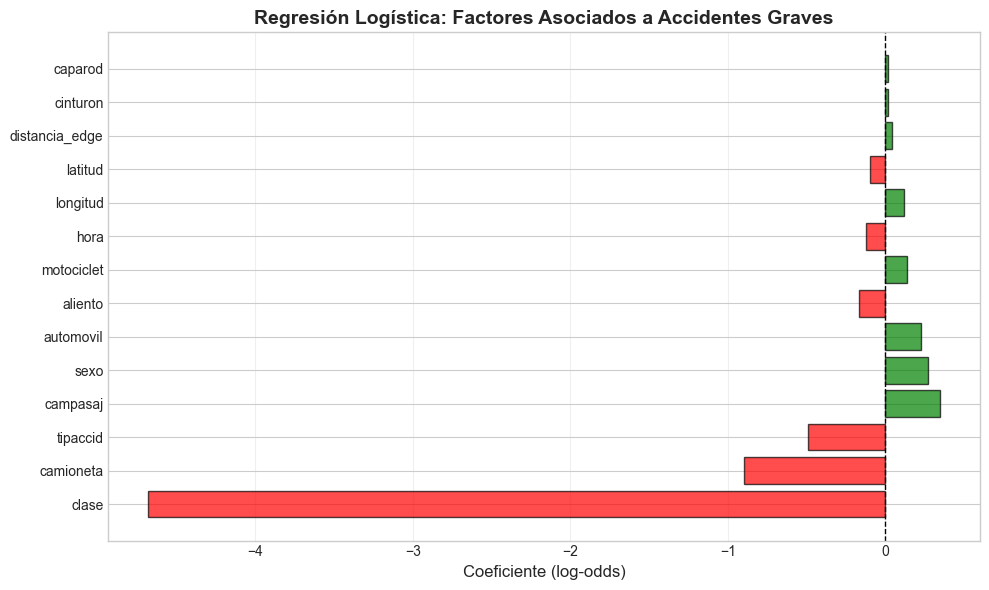

In [18]:
# Coeficientes de Regresión Logística
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": lr_clf.coef_[0]
}).sort_values("Coeficiente", key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["red" if x < 0 else "green" for x in coef_df["Coeficiente"]]
ax.barh(coef_df["Variable"], coef_df["Coeficiente"], color=colors, alpha=0.7, edgecolor="black")
ax.set_xlabel("Coeficiente (log-odds)", fontsize=12)
ax.set_title("Regresión Logística: Factores Asociados a Accidentes Graves",
            fontsize=14, fontweight="bold")
ax.axvline(0, color="black", linestyle="--", linewidth=1)
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

## 9. Modelo 4: Stacking Ensemble

In [19]:
# Stacking Ensemble con class_weight='balanced' en todos los modelos
estimators = [
    ('dt', DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
]

stacking_clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(class_weight='balanced', random_state=42), 
    cv=5
)
stacking_clf.fit(X_train_scaled, y_train)
y_pred_stack = stacking_clf.predict(X_test_scaled)

acc_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Ensemble Accuracy: {acc_stack:.4f}\n")
print(classification_report(y_test, y_pred_stack, target_names=['No grave', 'Grave']))

Stacking Ensemble Accuracy: 0.9016

              precision    recall  f1-score   support

    No grave       1.00      0.90      0.95      5197
       Grave       0.23      0.98      0.37       160

    accuracy                           0.90      5357
   macro avg       0.61      0.94      0.66      5357
weighted avg       0.98      0.90      0.93      5357



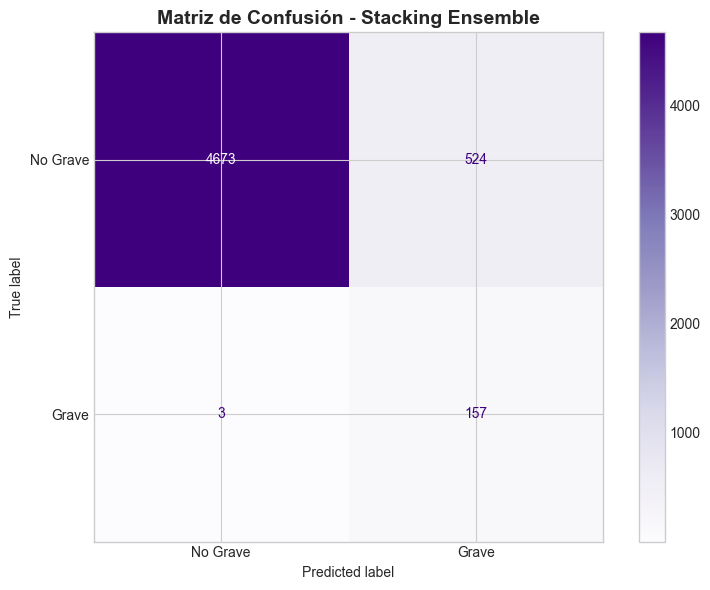

In [20]:
# Matriz de Confusión - Stacking Ensemble
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_stack,
                                       display_labels=["No Grave", "Grave"],
                                       cmap="Purples", ax=ax)
ax.set_title("Matriz de Confusión - Stacking Ensemble", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### 9.5 Comparación de Feature Importance: DT vs RF

Visualización comparativa de las importancias según cada algoritmo

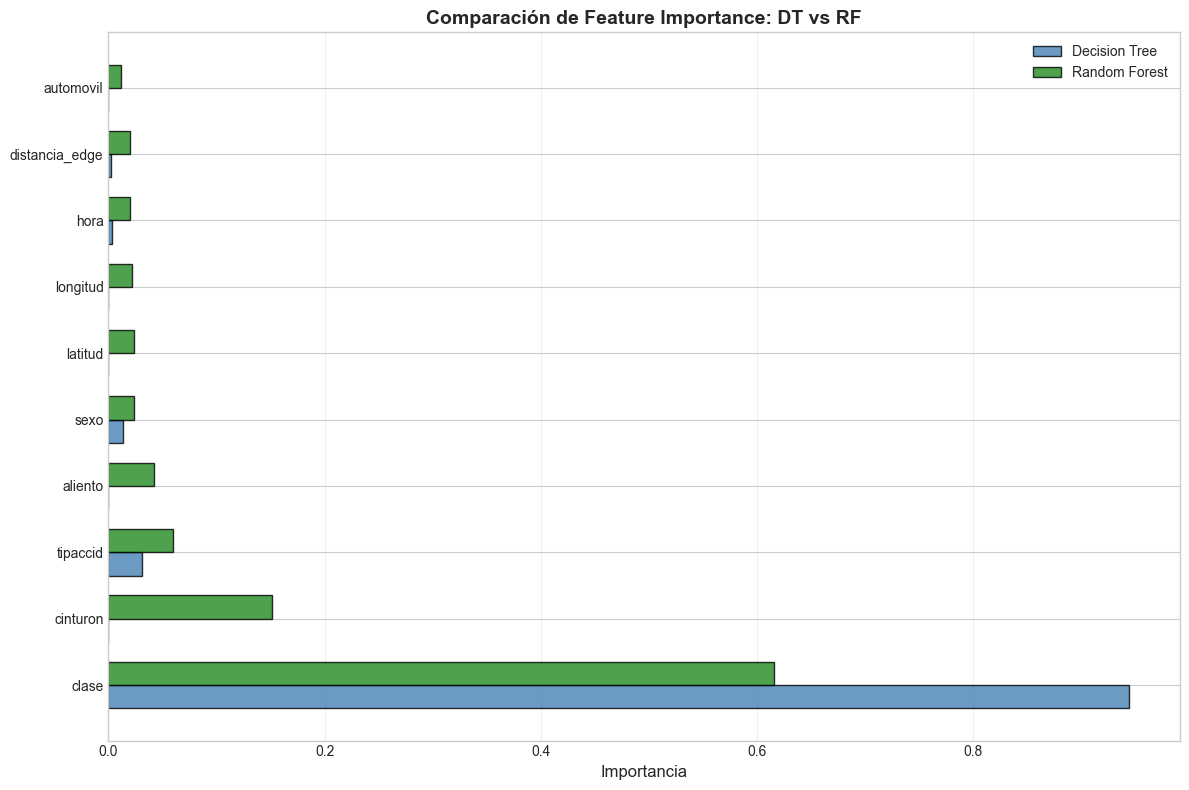

 Top 5 Features por modelo:
Decision Tree:
   feature  importance
     clase    0.944235
  tipaccid    0.031200
      sexo    0.013792
motociclet    0.004618
      hora    0.003377
Random Forest:
 feature  importance
   clase    0.615764
cinturon    0.151142
tipaccid    0.059490
 aliento    0.041997
    sexo    0.023891


In [21]:
# Comparación de Feature Importance: Decision Tree vs Random Forest
comparison = pd.merge(
    feature_imp_dt[["feature", "importance"]].rename(columns={"importance": "Importancia_Tree"}),
    feature_imp_rf[["feature", "importance"]].rename(columns={"importance": "Importancia_RF"}),
    on="feature"
).sort_values("Importancia_RF", ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
top10 = comparison.head(10)
x = np.arange(len(top10))
width = 0.35

ax.barh(x - width/2, top10["Importancia_Tree"], width, 
       label="Decision Tree", color="steelblue", alpha=0.8, edgecolor="black")
ax.barh(x + width/2, top10["Importancia_RF"], width,
       label="Random Forest", color="forestgreen", alpha=0.8, edgecolor="black")

ax.set_yticks(x)
ax.set_yticklabels(top10["feature"])
ax.set_xlabel("Importancia", fontsize=12)
ax.set_title("Comparación de Feature Importance: DT vs RF", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, axis="x")
plt.tight_layout()
plt.show()

print(" Top 5 Features por modelo:")
print("Decision Tree:")
print(feature_imp_dt.head(5).to_string(index=False))
print("Random Forest:")
print(feature_imp_rf.head(5).to_string(index=False))

## 10. Comparación de Modelos

Ranking de Modelos:
             Modelo  Accuracy
      Random Forest  0.924771
           Stacking  0.901624
Logistic Regression  0.899384
      Decision Tree  0.887064


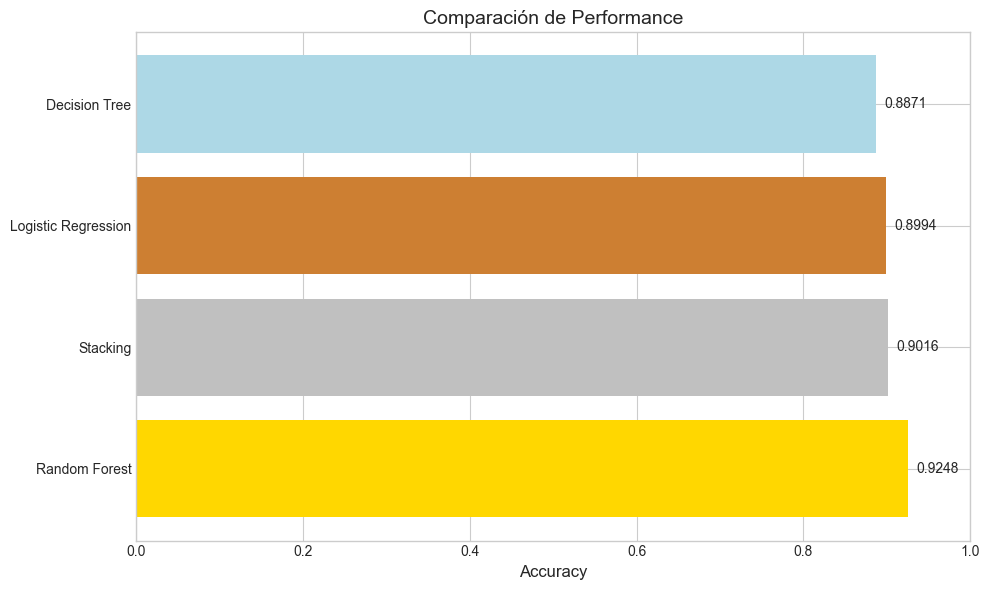

In [22]:
resultados = pd.DataFrame({
    'Modelo': ['Decision Tree', 'Random Forest', 'Logistic Regression', 'Stacking'],
    'Accuracy': [acc_dt, acc_rf, acc_lr, acc_stack]
}).sort_values('Accuracy', ascending=False)

print("Ranking de Modelos:")
print(resultados.to_string(index=False))

plt.figure(figsize=(10, 6))
# Colores válidos: gold (#FFD700), silver (#C0C0C0), bronze (#CD7F32), lightblue
plt.barh(resultados['Modelo'], resultados['Accuracy'], color=['#FFD700', '#C0C0C0', '#CD7F32', 'lightblue'])
plt.xlabel('Accuracy', fontsize=12)
plt.title('Comparación de Performance', fontsize=14)
plt.xlim(0, 1)
for i, v in enumerate(resultados['Accuracy']):
    plt.text(v + 0.01, i, f"{v:.4f}", va='center')
plt.tight_layout()
plt.show()

## 11. Curvas ROC

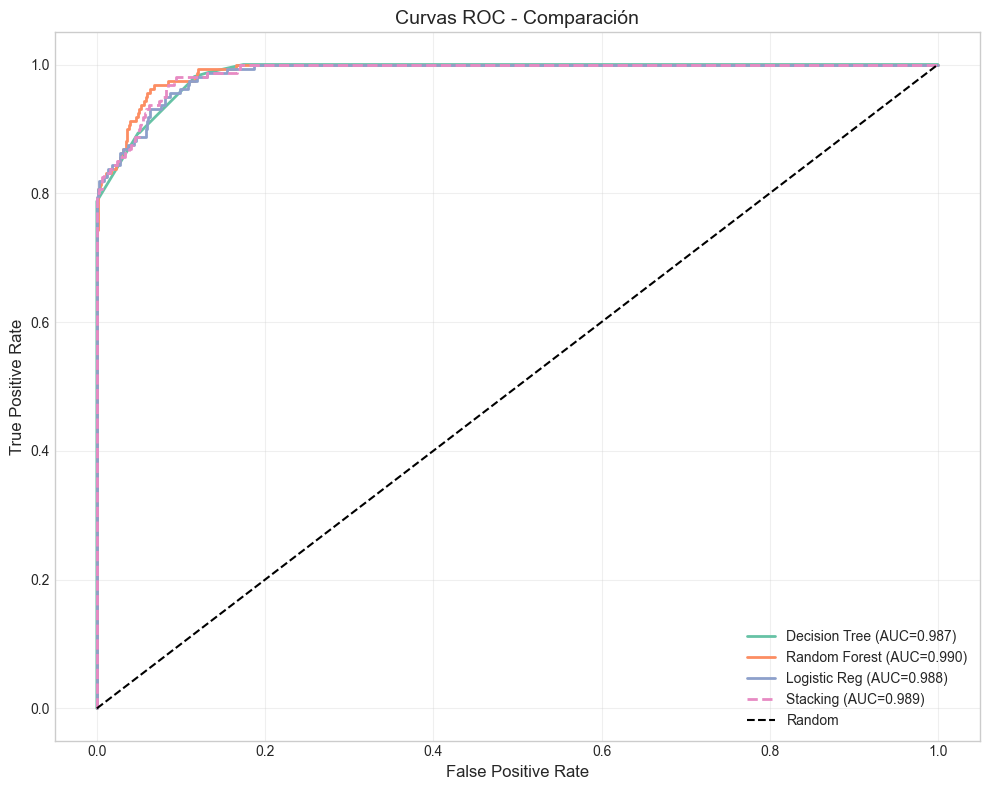

In [23]:
y_proba_dt = dt_clf.predict_proba(X_test)[:, 1]
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_proba_lr = lr_clf.predict_proba(X_test_scaled)[:, 1]
y_proba_stack = stacking_clf.predict_proba(X_test_scaled)[:, 1]

fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_stack, tpr_stack, _ = roc_curve(y_test, y_proba_stack)

auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_lr = auc(fpr_lr, tpr_lr)
auc_stack = auc(fpr_stack, tpr_stack)

plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={auc_dt:.3f})', linewidth=2)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', linewidth=2)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Reg (AUC={auc_lr:.3f})', linewidth=2)
plt.plot(fpr_stack, tpr_stack, label=f'Stacking (AUC={auc_stack:.3f})', linewidth=2, linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Curvas ROC - Comparación', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Generación de Scoring de Riesgo ML

In [24]:
mejor_modelo = rf_clf

X_all = df_model.drop('target_gravedad', axis=1)
riesgo_ml = mejor_modelo.predict_proba(X_all)[:, 1] * 100

df_model['riesgo_ml'] = riesgo_ml

df_model['indice_riesgo_compuesto'] = (
    0.4 * df_model.get('riesgo_cluster', 0) +
    0.6 * df_model['riesgo_ml']
)

print(f"✓ Scoring de riesgo ML generado")
print(f"\nEstadísticas del Índice Compuesto:")
print(df_model['indice_riesgo_compuesto'].describe())

✓ Scoring de riesgo ML generado

Estadísticas del Índice Compuesto:
count    26783.000000
mean         8.243914
std         13.292917
min          0.000000
25%          0.554918
50%          1.122927
75%          7.653739
max         58.656986
Name: indice_riesgo_compuesto, dtype: float64


## 13. Exportación de Modelos y Scoring

In [25]:
import os
os.makedirs('modelos', exist_ok=True)

# Guardar modelos
with open('modelos/modelo_riesgo_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

with open('modelos/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('modelos/feature_names.pkl', 'wb') as f:
    pickle.dump(list(X.columns), f)

# Crear dataset de exportación
# Necesitamos: riesgo_cluster (del df original), riesgo_ml (calculado), y coordenadas
df_export = pd.DataFrame()

# Agregar riesgo_ml (ya está en df_model)
df_export['riesgo_ml'] = df_model['riesgo_ml']

# Agregar riesgo_cluster desde df original (puede no estar en df_model)
if 'riesgo_cluster' in df.columns:
    # Alinear por índice
    df_export['riesgo_cluster'] = df.loc[df_model.index, 'riesgo_cluster'].values
else:
    print("⚠ riesgo_cluster no encontrado en df, usando 0")
    df_export['riesgo_cluster'] = 0

# Calcular índice compuesto
df_export['indice_riesgo_compuesto'] = (
    0.4 * df_export['riesgo_cluster'] +
    0.6 * df_export['riesgo_ml']
)

# Agregar coordenadas
if 'latitud' in df.columns and 'longitud' in df.columns:
    df_export['latitud'] = df.loc[df_model.index, 'latitud'].values
    df_export['longitud'] = df.loc[df_model.index, 'longitud'].values
    print(f"✓ Coordenadas agregadas al export")

# Agregar ID si existe para poder hacer merge después
if 'id' in df.columns:
    df_export['id'] = df.loc[df_model.index, 'id'].values
    print(f"✓ IDs agregados al export")

# Reordenar columnas
columnas_orden = ['riesgo_cluster', 'riesgo_ml', 'indice_riesgo_compuesto']
if 'latitud' in df_export.columns:
    columnas_orden.extend(['latitud', 'longitud'])
if 'id' in df_export.columns:
    columnas_orden.insert(0, 'id')
df_export = df_export[columnas_orden]

# Guardar
df_export.to_csv('Datos combinados CDMX/SCORING_RIESGO_COMPUESTO.csv', index=False)

print(f"\n✓ Archivos exportados:")
print(f"   - modelos/modelo_riesgo_rf.pkl")
print(f"   - modelos/scaler.pkl")
print(f"   - modelos/feature_names.pkl")
print(f"   - Datos combinados CDMX/SCORING_RIESGO_COMPUESTO.csv")
print(f"\n📊 Estadísticas del export:")
print(f"   Registros: {len(df_export):,}")
print(f"   Columnas: {list(df_export.columns)}")
print(f"   Riesgo ML promedio: {df_export['riesgo_ml'].mean():.2f}")
print(f"   Índice compuesto promedio: {df_export['indice_riesgo_compuesto'].mean():.2f}")

✓ Coordenadas agregadas al export
✓ IDs agregados al export

✓ Archivos exportados:
   - modelos/modelo_riesgo_rf.pkl
   - modelos/scaler.pkl
   - modelos/feature_names.pkl
   - Datos combinados CDMX/SCORING_RIESGO_COMPUESTO.csv

📊 Estadísticas del export:
   Registros: 26,783
   Columnas: ['id', 'riesgo_cluster', 'riesgo_ml', 'indice_riesgo_compuesto', 'latitud', 'longitud']
   Riesgo ML promedio: 13.74
   Índice compuesto promedio: 21.34


## Resumen

**Completado:**
- ✓ Feature engineering temporal y espacial
- ✓ 4 modelos de ML entrenados y evaluados
- ✓ Random Forest identificado como mejor modelo
- ✓ Análisis de feature importance
- ✓ Scoring de riesgo ML generado
- ✓ Índice de riesgo compuesto (clustering + ML)
- ✓ Modelos exportados para producción

**Siguiente paso:** [03_sistema_ruteo_zocalo_polanco.ipynb](03_sistema_ruteo_zocalo_polanco.ipynb) - Sistema de ruteo con ejemplo práctico